# Telco Churn Challenge

## 0 Import dependencies

In [ ]:
!pip install -r requirements.txt

In [292]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

## 1 Caricamento dataset e studio preliminare

In [293]:
path_file = './WA_Fn-UseC_-Telco-Customer-Churn.train.csv'
data = pd.read_csv(path_file)
data.head()
data_copy = data.copy()
data_copy.dtypes

Churn                object
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [294]:
categorical_cols = [col for col in data_copy.columns if data_copy[col].dtype == 'object']
categorical_cols

['Churn',
 'customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges']

In [295]:
data_copy.isnull().sum()

Churn               0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

## 2 Preprocessing

### 2.1 Ricerca e sostituzione stringhe vuote (impute missing variable)

In [296]:
indexes = []
for col in categorical_cols:
    count = 0
    for value in data_copy[col]:
        if not value.strip():
            count += 1
    if count != 0 :
        print(col, 'contiene' , count, 'stringhe vuote')

TotalCharges contiene 10 stringhe vuote


In [297]:
data_copy[['tenure', 'TotalCharges']][data_copy['tenure'] == 0]

,tenure,TotalCharges
4,0,
282,0,
2419,0,
2734,0,
2903,0,
3974,0,
5023,0,
5030,0,
5343,0,
5599,0,


In [298]:
#I valori stringa vuota di total charges corrispondono a clienti che non hanno ancora mai pagato, tenure è
#infatti 0. Sostituisco quindi stringa vuota con 0
data_copy.replace(to_replace = ' ', value = 0, inplace= True)

In [299]:
for col in data_copy.columns:
    print(col,data_copy[col].unique())

Churn ['No' 'Yes']
customerID ['4223-BKEOR' '6035-RIIOM' '3797-VTIDR' ... '8044-BGWPI' '7450-NWRTR'
 '4795-UXVCJ']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['No' 'Yes']
Dependents ['Yes' 'No']
tenure [21 54  1  4  0  7 32 72 19 10 45 40 47 36 69 71 35  3 68 42  8 46 12 26
 49 33 31 66 58 13 57  6 59 15 27 34 18  5 39 29  2 63 20 14 56 37 24 52
 43 11 16 50 38 23 55 48 53 70 22 28 44 65 64 60 51  9 25 61 30 17 41 67
 62]
PhoneService ['Yes' 'No']
MultipleLines ['No' 'Yes' 'No phone service']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['Yes' 'No' 'No internet service']
OnlineBackup ['No' 'Yes' 'No internet service']
DeviceProtection ['Yes' 'No' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['Yes' 'No' 'No internet service']
Contract ['One year' 'Two year' 'Month-to-month']
PaperlessBilling ['No' 'Yes']
PaymentMethod ['Mailed check' 'Bank transfer (automatic)' 'Electronic chec

### 2.2 Cast di TotalCharges a numerica

In [300]:
data_copy['TotalCharges'] = pd.to_numeric(data_copy['TotalCharges'],downcast = 'float')
data_copy['TotalCharges'].dtype

dtype('float32')

### 2.3 Eliminazione ridodanza 'No phone service' e 'No internet service'

In [301]:
# Columns 'phone service' and 'internet service' are already in the dataframe, I can collapse
# the values 'No phone service' and 'No internet service' in simple 'No'
data_copy['MultipleLines'].replace(to_replace ='No phone service' , value = 'No', inplace = True)
data_copy['OnlineSecurity'].replace(to_replace ='No internet service' , value = 'No', inplace = True)
data_copy['OnlineBackup'].replace(to_replace ='No internet service' , value = 'No', inplace = True)
data_copy['DeviceProtection'].replace(to_replace ='No internet service' , value = 'No', inplace = True)
data_copy['TechSupport'].replace(to_replace ='No internet service' , value = 'No', inplace = True)
data_copy['StreamingTV'].replace(to_replace ='No internet service' , value = 'No', inplace = True)
data_copy['StreamingMovies'].replace(to_replace ='No internet service' , value = 'No', inplace = True)

In [302]:
data_copy[categorical_cols].nunique()

Churn                  2
customerID          5634
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          2
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        5300
dtype: int64

## 3 Tentativo Analisi dati

### 3.1 Numerical features

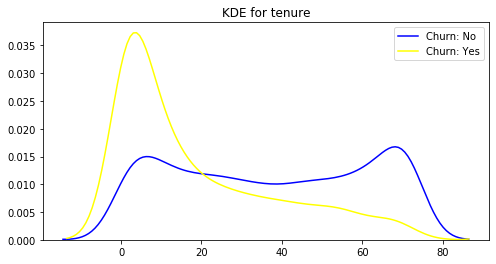

In [303]:
plt.figure(figsize=(8, 4))
plt.title("KDE for {}".format('tenure'))
ax0 = sns.kdeplot(data_copy[data_copy['Churn'] == 'No']['tenure'].dropna(), color= 'blue', label= 'Churn: No')
ax1 = sns.kdeplot(data_copy[data_copy['Churn'] == 'Yes']['tenure'].dropna(), color= 'yellow', label= 'Churn: Yes')

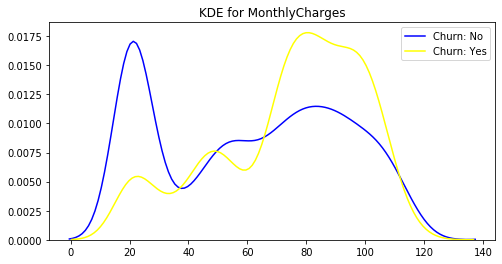

In [304]:
plt.figure(figsize=(8, 4))
plt.title("KDE for {}".format('MonthlyCharges'))
ax0 = sns.kdeplot(data_copy[data_copy['Churn'] == 'No']['MonthlyCharges'].dropna(), color= 'blue', label= 'Churn: No')
ax1 = sns.kdeplot(data_copy[data_copy['Churn'] == 'Yes']['MonthlyCharges'].dropna(), color= 'yellow', label= 'Churn: Yes')

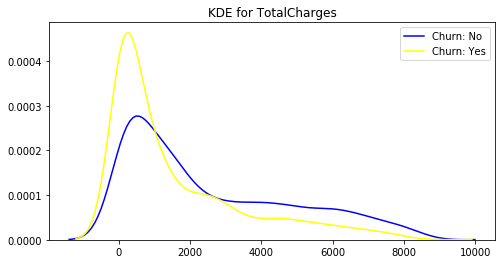

In [305]:
plt.figure(figsize=(8, 4))
plt.title("KDE for {}".format('TotalCharges'))
ax0 = sns.kdeplot(data_copy[data_copy['Churn'] == 'No']['TotalCharges'].dropna(), color= 'blue', label= 'Churn: No')
ax1 = sns.kdeplot(data_copy[data_copy['Churn'] == 'Yes']['TotalCharges'].dropna(), color= 'yellow', label= 'Churn: Yes')

Dai plot si può dedurre che quanto un cliente paga (MonthlyCharges e TotalCharges) è sicuramente un buon indicatore della possibilità di churn. Inoltre un nuovo cliente (tenure basso) ha una probabilità di churn molto più alta.
Si può concludere che probabilmente tutte e tre le feature numeriche sono importanti ai fini della modellazione, come si poteva già suppore a priori data la conoscenza del fenomeno.

### 3.2 Categorical feature

#### 3.2.1 Senior Citizen

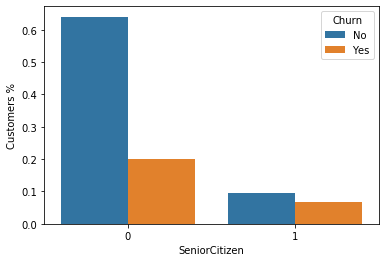

In [306]:
d = data_copy.groupby('SeniorCitizen')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='SeniorCitizen', y= 'Customers %',orient='v', hue='Churn', data=d)

Anche se solo una bassa percentuale di customer è senior sono proprio questi ultimi ad avere un'alta percentuale di churn come si può evincere dal grafico (circa il 10% sul 30% di churn totale). Probabilmente una feature da tenere in considerazione

#### 3.2.2 Gender

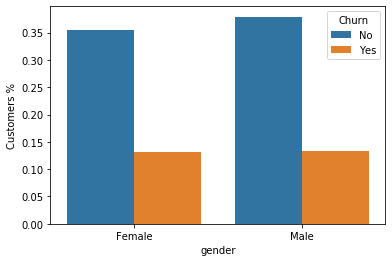

In [307]:
d = data_copy.groupby('gender')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='gender', y= 'Customers %',orient='v', hue='Churn', data=d)

Uomini e donne sono equamente distribuiti nella popolazione totale e hanno comportamenti del tutto identici rispetto alla possibilità di churn.

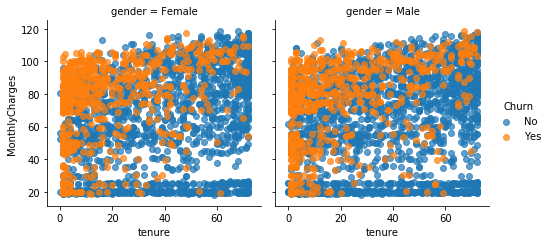

In [308]:
g = sns.FacetGrid(data_copy, col="gender", hue="Churn", height=3.5)
g.map(plt.scatter, 'tenure', 'MonthlyCharges', alpha=0.7)
g.add_legend();

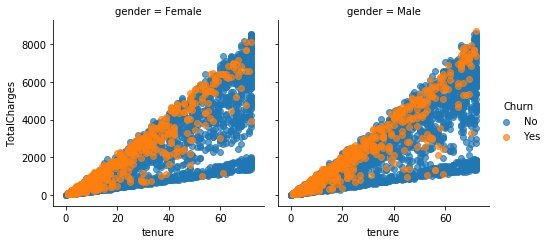

In [309]:
g = sns.FacetGrid(data_copy, col="gender", hue="Churn", height=3.5)
g.map(plt.scatter, 'tenure', 'TotalCharges', alpha=0.7)
g.add_legend();

Gender non sembra nemmeno avere comportamenti diversi rispetto alle categorie numeriche.

In conclusione si suppone che possa essere scartata perchè non significativa.

#### 3.2.3 Partner

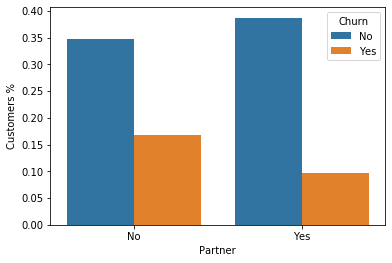

In [310]:
d = data_copy.groupby('Partner')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='Partner', y= 'Customers %',orient='v', hue='Churn', data=d)

Circa il 50% del dataset non ha un partner e viceversa, ma chi non ha un partner ha quasi una possibilità doppia di fare churn, si può concludere che probabilmente questa sia feature significativa da mantenere.

#### 3.2.4 Dependents 

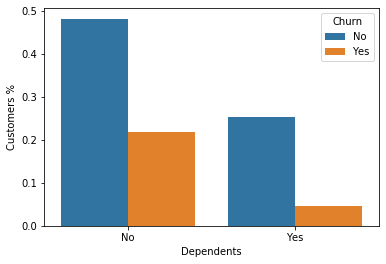

In [311]:
d = data_copy.groupby('Dependents')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='Dependents', y= 'Customers %',orient='v', hue='Churn', data=d)

Anche se la popolazione risulta essere sbilanciata circa 70-30, al no corrispone una più alta possibilità di churn, probabilmente una feature da mantenere.

### 3.2.5 Phone Service e servzi addizionali

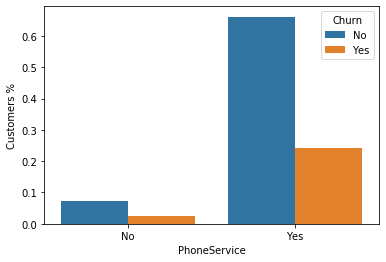

In [312]:
d = data_copy.groupby('PhoneService')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='PhoneService', y= 'Customers %',orient='v', hue='Churn', data=d)

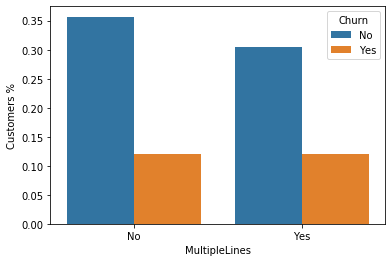

In [313]:
#Per escludere chi non ha proprio il servizio telefonico dai 'no' del MultipleLines
d = data_copy[(data_copy.PhoneService != "No")]

d = d.groupby('MultipleLines')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='MultipleLines', y= 'Customers %',orient='v', hue='Churn', data=d)


La maggior parte della popolazione risulta avere una linea telefonica, di questi chi ha più linee risulta avere una debole possibilità in più di fare churn (stessa % di customer con churn yes ma su una popolazione totale leggermente inferiore). Entrambe le feature risultano quindi essere significative probabilmente.

### 3.2.6 Internet Service e servizi addizionali

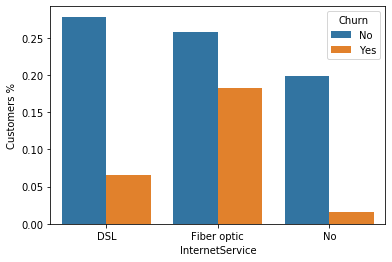

In [314]:
d = data_copy.groupby('InternetService')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='InternetService', y= 'Customers %',orient='v', hue='Churn', data=d)

Risulta evidente che tra chi possiede il servizio internet con la fibra ottica ha una più alta possibilità di churn (18% su una popolazione totale del 43% circa) rispetto a chi non ce l'ha o ha la DSL. Sicuramente significativa.

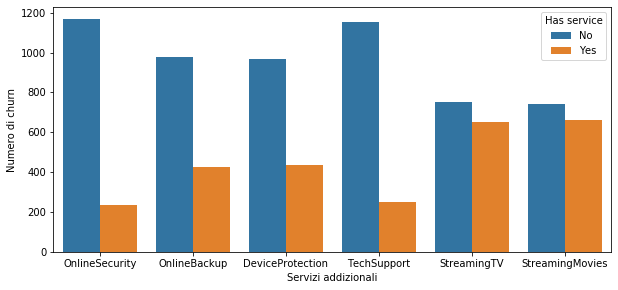

In [315]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
plt.figure(figsize=(10, 4.5))
d1 = data_copy[(data_copy.InternetService != "No") & (data_copy.Churn == "Yes")]
d1 = pd.melt(d1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=d1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Servizi addizionali', ylabel='Numero di churn')
plt.show()

Tra tutti i servizi quelli di Streaming hanno solo un leggero impatto sul numero di churn. Sarebbe utile provare ad eliminarle come features.

### 3.3.7 Payment method

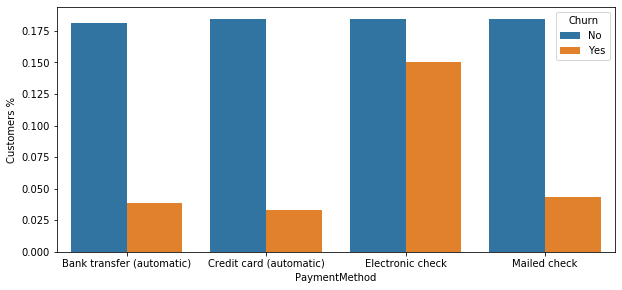

In [316]:
plt.figure(figsize=(10, 4.5))
d = data_copy.groupby('PaymentMethod')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='PaymentMethod', y= 'Customers %',orient='v', hue='Churn', data=d)

Electronic check risulta essere l'opzione più popolosa e anche quella con una più alta possibilità di churn, PaymentMethod può essere quindi considerata una feature utile.

### 3.3.8 Contract

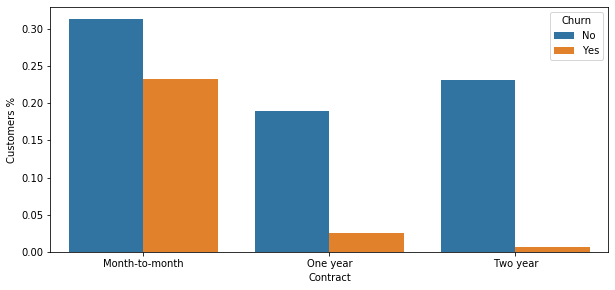

In [317]:
plt.figure(figsize=(10, 4.5))
d = data_copy.groupby('Contract')["Churn"].value_counts().to_frame()
d = d.rename({"Churn": 'Customers %'}, axis=1).reset_index()
d['Customers %'] = d['Customers %']/len(data_copy)
ax = sns.barplot(x='Contract', y= 'Customers %',orient='v', hue='Churn', data=d)

Anche questa risulta essere una feature rilevante, in particolare nel caso Month-to-month per motivazioni similari a quelle del payment.

## 4 Split del dataset in train e validation

In [318]:
y = data_copy.Churn
X = data_copy.drop(['Churn', 'gender','StreamingTV','StreamingMovies'], axis = 1)
#CustomerID doesn't provide usefull information
X.drop(['customerID'], axis = 1, inplace = True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.25, random_state = 1)

## 5 Label encoding colonne categoriche

In [319]:
#Il label lo faccio dopo lo split per evitare una contaminazione dei dati di train con i valori del validation

categorical_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
numerical_cols = [col for col in X_train.columns if X_train[col].dtype == 'int64' 
                                                          or X_train[col].dtype == 'float64' 
                                                          or X_train[col].dtype == 'float32']

# Categorical columns that can be safely encoded
good_label_cols = [col for col in categorical_cols if set(X_train[col]) == set(X_valid[col])]

bad_label_cols = list(set(X_valid.columns)-set(good_label_cols) - set(numerical_cols))

print('\nCategorical columns that have unique values in validation that are not present in training:', bad_label_cols)


Categorical columns that have unique values in validation that are not present in training: []


In [320]:
for col in X_train[categorical_cols]:
    print (col, '      ', X_train[col].unique())

Partner        ['No' 'Yes']
Dependents        ['No' 'Yes']
PhoneService        ['Yes' 'No']
MultipleLines        ['No' 'Yes']
InternetService        ['DSL' 'Fiber optic' 'No']
OnlineSecurity        ['Yes' 'No']
OnlineBackup        ['Yes' 'No']
DeviceProtection        ['No' 'Yes']
TechSupport        ['Yes' 'No']
Contract        ['One year' 'Month-to-month' 'Two year']
PaperlessBilling        ['No' 'Yes']
PaymentMethod        ['Bank transfer (automatic)' 'Electronic check' 'Credit card (automatic)'
 'Mailed check']


In [321]:
#Ho voluto provare a farlo a mano stavolta invece di usare il labelEncoder
X_train.Partner = X_train.Partner.map({'No' : 0,'Yes': 1})
X_valid.Partner = X_valid.Partner.map({'No' : 0,'Yes': 1})

X_train.Dependents = X_train.Dependents.map({'No' : 0,'Yes': 1})
X_valid.Dependents = X_valid.Dependents.map({'No' : 0,'Yes': 1})

X_train.PhoneService = X_train.PhoneService.map({'No' : 0,'Yes': 1})
X_valid.PhoneService = X_valid.PhoneService.map({'No' : 0,'Yes': 1})

X_train.MultipleLines = X_train.MultipleLines.map({'No' : 0,'Yes': 1})
X_valid.MultipleLines = X_valid.MultipleLines.map({'No' : 0,'Yes': 1})

X_train.OnlineSecurity = X_train.OnlineSecurity.map({'No' : 0,'Yes': 1})
X_valid.OnlineSecurity = X_valid.OnlineSecurity.map({'No' : 0,'Yes': 1})

X_train.OnlineBackup = X_train.OnlineBackup.map({'No' : 0,'Yes': 1})
X_valid.OnlineBackup = X_valid.OnlineBackup.map({'No' : 0,'Yes': 1})

X_train.DeviceProtection = X_train.DeviceProtection.map({'No' : 0,'Yes': 1})
X_valid.DeviceProtection = X_valid.DeviceProtection.map({'No' : 0,'Yes': 1})

X_train.TechSupport = X_train.TechSupport.map({'No' : 0,'Yes': 1})
X_valid.TechSupport = X_valid.TechSupport.map({'No' : 0,'Yes': 1})

#X_train.StreamingTV = X_train.StreamingTV.map({'No' : 0,'Yes': 1})
#X_valid.StreamingTV = X_valid.StreamingTV.map({'No' : 0,'Yes': 1})

#X_train.StreamingMovies = X_train.StreamingMovies.map({'No' : 0,'Yes': 1})
#X_valid.StreamingMovies = X_valid.StreamingMovies.map({'No' : 0,'Yes': 1})

X_train.PaperlessBilling = X_train.PaperlessBilling.map({'No' : 0,'Yes': 1})
X_valid.PaperlessBilling = X_valid.PaperlessBilling.map({'No' : 0,'Yes': 1})

#X_train.gender = X_train.gender.map({'Female' : 0,'Male': 1})
#X_valid.gender = X_valid.gender.map({'Female' : 0,'Male': 1})

X_train.InternetService = X_train.InternetService.map({'No' : 0,'DSL': 1, 'Fiber optic' : 2})
X_valid.InternetService = X_valid.InternetService.map({'No' : 0,'DSL': 1, 'Fiber optic' : 2})

X_train.Contract = X_train.Contract.map({'Month-to-month' : 0,'One year': 1, 'Two year' : 2})
X_valid.Contract = X_valid.Contract.map({'Month-to-month' : 0,'One year': 1, 'Two year' : 2})

X_train.PaymentMethod = X_train.PaymentMethod.map({'Bank transfer (automatic)' : 3,'Mailed check': 0, 
                                                   'Electronic check' : 1, 'Credit card (automatic)' : 2})
X_valid.PaymentMethod = X_valid.PaymentMethod.map({'Bank transfer (automatic)' : 3,'Mailed check': 0, 
                                                   'Electronic check' : 1, 'Credit card (automatic)' : 2})

for col in X_train.columns:
    print(col,X_train[col].unique())
    
for col in X_valid.columns:
    print(col,X_valid[col].unique())

SeniorCitizen [0 1]
Partner [0 1]
Dependents [0 1]
tenure [ 8 23  4 26 30 66 71 33 65  1 20 67 53 15 55 61 14 58 64 40 37 72  3 24
 22 13 34 46  5  2 18 50 45 39 12 47 31 11 32  9 54 69 10 27  7 29 16 44
 38 42 63 35 68 57 49 56 51  6 70 60 41 17 36 52 19 48 43 25 59 28 21 62
  0]
PhoneService [1 0]
MultipleLines [0 1]
InternetService [1 2 0]
OnlineSecurity [1 0]
OnlineBackup [1 0]
DeviceProtection [0 1]
TechSupport [1 0]
Contract [1 0 2]
PaperlessBilling [0 1]
PaymentMethod [3 1 2 0]
MonthlyCharges [ 58.2   90.05  77.85 ...  81.1   97.35 113.4 ]
TotalCharges [ 469.25 2169.8   299.2  ... 8164.1  5825.5   450.65]
SeniorCitizen [0 1]
Partner [0 1]
Dependents [0 1]
tenure [41 23  3 56 18 48 13 10 36  2  6  1 61 27 66 65 63  4 28 17 26 51 31 43
 19 60 57 72 42 52 12 37 29 71 40 38 16 44 64  8 11  0 50 22 62  9 58 25
 46  5 34 32 33 70 47 39 68 35 24 49 55 20 53 54 69  7 30 59 67 14 15 45
 21]
PhoneService [1 0]
MultipleLines [0 1]
InternetService [0 1 2]
OnlineSecurity [0 1]
OnlineBackup [

/home/mattia/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## 6 Scelta del modello e dei parametri

In [322]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_valid)

lr = LogisticRegression(max_iter = 150)
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_valid)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_valid)

In [323]:
validation_accuracy_rf = []
   
validation_accuracy_rf.append(rf.score(X_valid, y_valid))

print('Validation accuracy random forest: ', validation_accuracy_rf)

validation_accuracy_lr = []
   
validation_accuracy_lr.append(lr.score(X_valid, y_valid))

print('Validation accuracy logistic regression: ', validation_accuracy_lr)

validation_accuracy_knn = []
   
validation_accuracy_knn.append(knn.score(X_valid, y_valid))

print('Validation accuracy KNN: ', validation_accuracy_rf)

Validation accuracy random forest:  [0.7927608232789212]
Validation accuracy logistic regression:  [0.7955997161107168]
Validation accuracy KNN:  [0.7927608232789212]


In [324]:
depths = [3,4,5,6,7,8,9,10,11,12,15,20]

for depth in depths:
    model = RandomForestClassifier(random_state = 3, max_depth = depth)
    model.fit(X_train, y_train)
    score = model.score(X_valid, y_valid)
    print('With depth: ', depth, 'score: ', score)

With depth:  3 score:  0.7963094393186657
With depth:  4 score:  0.8019872249822569
With depth:  5 score:  0.7984386089425124
With depth:  6 score:  0.8005677785663591
With depth:  7 score:  0.8005677785663591
With depth:  8 score:  0.8019872249822569
With depth:  9 score:  0.8055358410220014
With depth:  10 score:  0.8055358410220014
With depth:  11 score:  0.7977288857345636
With depth:  12 score:  0.7927608232789212
With depth:  15 score:  0.7856635911994322
With depth:  20 score:  0.7842441447835344


In [325]:
estimators = [50,100,150,200,230,250]
depths = range(6,11)
tests = [ (estimator, depth) for estimator in estimators for depth in depths]

for test in tests:
    estimator, depth = test
    model = RandomForestClassifier(random_state = 3, n_estimators = estimator, max_depth = depth)
    model.fit(X_train, y_train)
    score = model.score(X_valid, y_valid)
    print('With test: ', test, 'score: ', score)

With test:  (50, 6) score:  0.7984386089425124
With test:  (50, 7) score:  0.8026969481902059
With test:  (50, 8) score:  0.8019872249822569
With test:  (50, 9) score:  0.8062455642299503
With test:  (50, 10) score:  0.8076650106458482
With test:  (100, 6) score:  0.8005677785663591
With test:  (100, 7) score:  0.8005677785663591
With test:  (100, 8) score:  0.8019872249822569
With test:  (100, 9) score:  0.8055358410220014
With test:  (100, 10) score:  0.8055358410220014
With test:  (150, 6) score:  0.801277501774308
With test:  (150, 7) score:  0.8034066713981547
With test:  (150, 8) score:  0.8026969481902059
With test:  (150, 9) score:  0.8048261178140526
With test:  (150, 10) score:  0.8090844570617459
With test:  (200, 6) score:  0.8019872249822569
With test:  (200, 7) score:  0.8069552874378992
With test:  (200, 8) score:  0.801277501774308
With test:  (200, 9) score:  0.8069552874378992
With test:  (200, 10) score:  0.8090844570617459
With test:  (230, 6) score:  0.802696948190

## 7 Modello finale e stampa dell'accuracy

In [326]:
rf_final = RandomForestClassifier(random_state = 3,n_estimators = 230, max_depth = 10)
rf_final.fit(X_train, y_train)
predictions_rf_final = rf_final.predict(X_valid)

### 7.1 Confusion Matrix

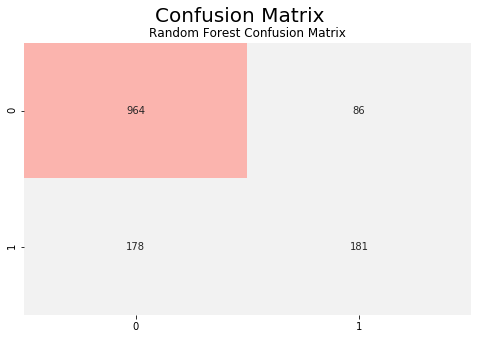

In [327]:
confusion_matrix= metrics.confusion_matrix(y_valid, predictions_rf_final)

plt.figure(figsize=(8,5))

plt.suptitle("Confusion Matrix",fontsize=20)

plt.subplot(1,1,1)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(confusion_matrix, cbar=False,annot=True,cmap="Pastel1_r",fmt="d")

plt.show()

### 7.2 Stampa accuracy

In [328]:
validation_accuracy = []
   
validation_accuracy.append(model.score(X_valid, y_valid))

print('Validation accuracy: ', validation_accuracy)

Validation accuracy:  [0.8112136266855926]
